## Microbenchmarks

Adapted from https://github.com/TheSalon/fast-dpsgd/blob/main/results/runtimes.ipynb

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 200)
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
RAW = 'raw'
RUNS = 100
REPEATS = 25

## Data Preprocessing

In [4]:
naming = {
    'mha': 'MHA',
    'rnn': 'RNN',
    'gru': 'GRU',
    'lstm': 'LSTM',
    'layernorm': 'LayerNorm',
    'instancenorm': 'InstanceNorm',
    'groupnorm': 'GroupNorm',
}

layers = ['rnn', 'gru', 'lstm', 'mha']
names = ['conv', 'layernorm', 'instancenorm', 'groupnorm', 'linear', 'embedding', 'mha', 'rnn', 'gru', 'lstm']
gsm_names = ['gsm_' + name if name not in layers else 'gsm_dp' + name for name in names]
batch_sizes = [16, 32, 64, 128, 256, 512]
pretty_names = [name.capitalize() if name not in naming else naming[name] for name in names]
gsm_pretty_names = ['GSM(' + name + ')' if i<6 else 'GSM(DP' + name + ')' for i, name in enumerate(pretty_names)]
gsm_pretty_names

['GSM(Conv)',
 'GSM(LayerNorm)',
 'GSM(InstanceNorm)',
 'GSM(GroupNorm)',
 'GSM(Linear)',
 'GSM(Embedding)',
 'GSM(DPMHA)',
 'GSM(DPRNN)',
 'GSM(DPGRU)',
 'GSM(DPLSTM)']

In [5]:
def generate_df(names, pnames):
    
    def expt_iterator(names):
        for name, pname in zip(names, pnames):
            for bs in batch_sizes:
                yield name, pname, bs
    files = []
    success, errors = 0, 0
    for name, pname, bs in expt_iterator(names):
        pickle_name = f'./{RAW}/{name}_bs_{bs}_runs_{RUNS}_repeats_{REPEATS}'

        try:
            with open(pickle_name+'.pkl', 'rb') as f:
                d = pickle.load(f)
                assert(len(d['runtime']) == RUNS)
                assert(len(d['memory']) == RUNS)
            files.append((name, pname, bs, d))
            success += 1
        except:
            errors += 1
            
    print(success, errors)
    df_list = []
    for *row, d in files:
        d = d['runtime'] + [m-b for b, m in d['memory']]
        df_list.append(pd.Series(row + d))

    df = pd.concat(df_list, axis=1).transpose()
    df.columns = ['File', 'Layer', 'Batch Size'] + [f'Runtime {i}' for i in range(RUNS)] + [f'Memory {i}' for i in range(RUNS)]
    return df

In [6]:
nn = generate_df(names, pretty_names)
opacus = generate_df(gsm_names, gsm_pretty_names)

# opacus['nans'] = opacus.isnull().sum(axis=1) / 2    
# opacus[opacus['nans'] > 0].sort_values(by=['Layer'])

# nn['nans'] = nn.isnull().sum(axis=1) / 2    
# nn[nn['nans'] > 0].sort_values(by=['Layer'])

opacus.isnull().sum(axis=1) / 2    

60 0
60 0


0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
45    0.0
46    0.0
47    0.0
48    0.0
49    0.0
50    0.0
51    0.0
52    0.0
53    0.0
54    0.0
55    0.0
56    0.0
57    0.0
58    0.0
59    0.0
dtype: float64

In [7]:
factors = nn.copy()

for item in ['Runtime', 'Memory']:
    for i in range(RUNS):
        factors[f"{item} {i}"] =  opacus[f"{item} {i}"] / factors[f"{item} {i}"] 

factors['nans'] = factors.isnull().sum(axis=1) / 2    

for item in ['Runtime', 'Memory']:
    factors[f'Median {item}'] = factors[[f'{item} {i}' for i in range(RUNS)]].median(axis = 1)

df = factors[['File', 'Layer', 'Batch Size', 'Median Runtime', 'Median Memory', 'nans']].copy()

In [8]:
df['Order'] = -1
for i,name in enumerate(names):
    df.loc[df['File'] == name, 'Order'] = i
assert not (df['Order'] == -1).sum()
df = df.sort_values(by=['Batch Size', 'Order'])
df[df['nans'] > 0].sort_values(by=['Layer'])

,File,Layer,Batch Size,Median Runtime,Median Memory,nans,Order


In [9]:
count = len(pd.unique(df['Batch Size']))
PALETTE = sns.color_palette(palette='Blues', n_colors=count+2, desat=None, as_cmap=False)[1:]
PALETTE = PALETTE[:count]

def get_runtime_plot(ax, item, ylim=None, figsize=(13, 6)): 
    sns.set_style("whitegrid")
    plot_df = df.copy()
    sns.barplot(
        x='Layer',
        y=f'Median {item}',
        hue='Batch Size',
        data=plot_df,
        ax=ax,
        palette=PALETTE
    )
    WIDTH = 0.15

    tmp = df[f'Median {item}']
    for i, (rect, tim) in enumerate(zip(ax.patches, tmp)):
        width = rect.get_width()
        rect.set_width(width-(width*0.15))
        (x, y) = rect.get_xy()
        rect.set_xy((x + width*0.15, y))
        height = rect.get_height()
        if tim > 100.:
            annotation = f'{int(tim)}'
        elif tim > 0.:
            annotation = f'{tim:.2g}'
        else:
            annotation = ''
        ax.annotate(
            annotation,
            xy=(
                rect.get_x() + rect.get_width() / 2 - 0.5*rect.get_width(), 
                min(height, ylim)
            ),
            xytext=(
                rect.get_x() + rect.get_width() / 2 - 0.5*rect.get_width(), 
                min(height + ylim/figsize[1]*0.08, ylim+ ylim/figsize[1]*0.07)
            ),  # 3 points vertical offset
            textcoords='data',
            va='bottom', ha='left', 
            fontsize=9, rotation=90)

    plt.title('')
    if item == 'Runtime':
        # ax.set_title('Median factor of slowdown from adding DP')
        ax.set_ylabel('Runtime increase (factor)')
    else:
        # ax.set_title('Median factor of memory increase from adding DP')
        ax.set_ylabel('Memory increase (factor)')
           
    ax.set_xlabel('Layer')
    if ylim:
        ax.set_ylim(0, ylim)
    ax.get_legend().remove()
    sns.despine()
    ax.legend(loc='upper left')
    f.patch.set_facecolor('white')
    f.tight_layout()
    return f, ax

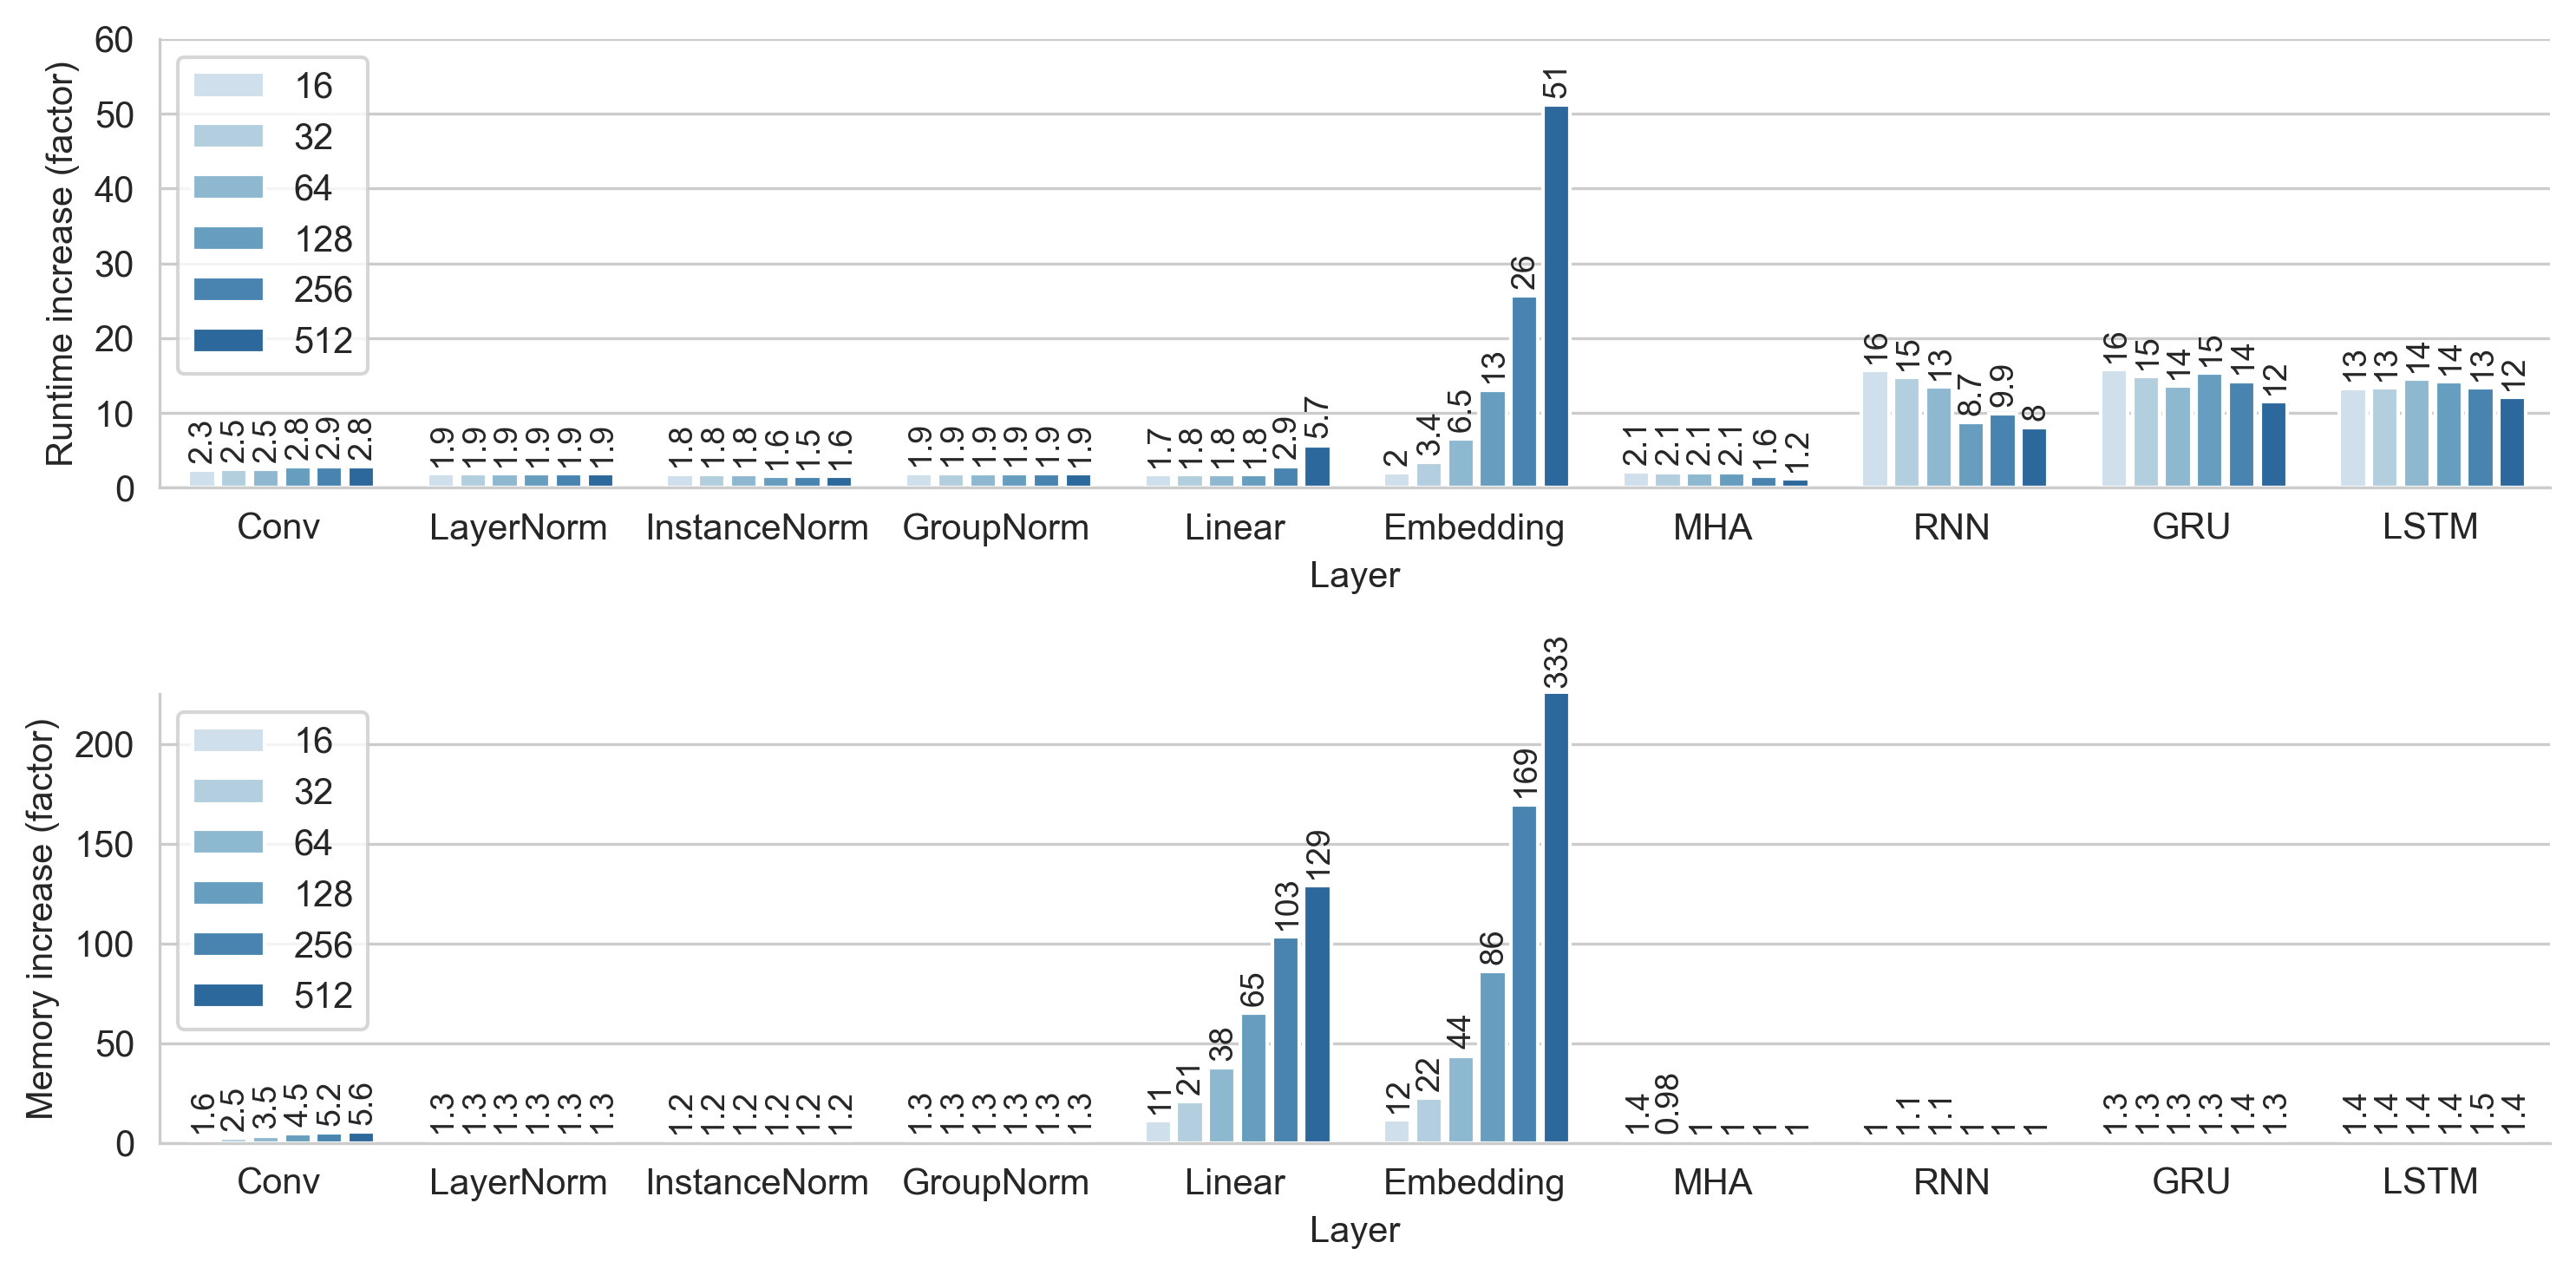

In [12]:
FIGSIZE = (10, 5)

f, ax = plt.subplots(2, 1, figsize=FIGSIZE, sharey=False)
f, ax0 = get_runtime_plot(ax[0], 'Runtime', 60, figsize=FIGSIZE)
f, ax1 = get_runtime_plot(ax[1], 'Memory', 225, figsize=FIGSIZE)
f.savefig('./figures/microbe.pdf')